In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cpu')

In [38]:
data = pd.read_csv("../preprocessed_data/data_with_removals_encoded.csv")
#data = pd.read_csv("../preprocessed_data/data_without_promoted_teams.csv")
#data = pd.read_csv("../preprocessed_data/data_with_30_most_important_features.csv")

data.head()

,FTR,HomeTeamGoalDifferencePGOverall,AwayTeamGoalDifferencePGOverall,AwayTeamGoalsScoredPGOverall,AwayTeamPointsPGOverall,HomeTeamPointsPGOverall,AwayTeamShotsPGOverall,AwayTeamShotsPGOverallAgainstOpponent,HomeTeamGoalDifferencePGAtHome,HomeTeamGoalsScoredPGOverall,...,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,A,-0.367340,-0.656304,-0.425987,-0.730073,-0.082885,-0.808118,0.238706,0.317921,-0.091731,...,False,False,False,False,False,False,False,False,False,False
1,H,-1.001396,-0.649823,-0.969588,-1.145612,-0.719893,-0.318423,-1.993921,-0.654454,-0.969336,...,False,False,False,False,False,False,False,False,False,False
2,H,0.816232,-0.403990,-0.762687,-0.089695,0.936328,-0.564847,-0.246647,0.542315,0.853381,...,True,False,False,False,False,False,False,False,False,False
3,A,-0.578692,-0.342646,-1.243815,-1.291190,-0.337688,-0.972897,-1.993921,-0.205666,-0.834320,...,False,False,False,False,False,False,False,False,False,False
4,H,1.281206,-0.277833,-0.425987,-0.730073,1.000029,0.177129,0.238706,1.365095,1.325938,...,False,False,False,False,False,False,False,True,False,False


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Columns: 115 entries, FTR to AwayTeam_Wolves
dtypes: bool(84), float64(30), object(1)
memory usage: 2.5+ MB


In [40]:
label_encoder = LabelEncoder()
data['FTR_encoded'] = label_encoder.fit_transform(data['FTR'])
data_encoded =data.drop(columns=['FTR'])

data_encoded = data_encoded.astype({col: np.float64 for col in data_encoded.columns if col != 'FTR_encoded'})

In [41]:
# Train, validation, test split
temp_data, test_data = train_test_split(data_encoded, test_size=0.1, random_state=42)
train_data, valid_data = train_test_split(temp_data, test_size=0.2, random_state=42)

X_train = torch.tensor(train_data.drop(columns=['FTR_encoded']).values, dtype=torch.float32)
y_train = torch.tensor(train_data['FTR_encoded'].values, dtype=torch.long)
X_valid = torch.tensor(valid_data.drop(columns=['FTR_encoded']).values, dtype=torch.float32)
y_valid = torch.tensor(valid_data['FTR_encoded'].values, dtype=torch.long)


In [45]:
alpha = 1e-3

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
        
    def l1_loss(self):
        # Calculate L1 regularization term
        l1_reg = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        return l1_reg
    def l2_loss(self):
        # Calculate L2 regularization term
        l2_reg = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l2_reg = l2_reg + torch.norm(param, 2)
        return l2_reg


In [46]:
input_size = X_train.shape[1]
hidden_size = 32
output_size = 3

reg = None

learning_rate = 0.00001
num_epochs = 100

model = SimpleMLP(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/100], Train Loss: 1.1261, Train Acc: 0.2936, Valid Loss: 1.1259, Valid Acc: 0.2816
Epoch [2/100], Train Loss: 1.1227, Train Acc: 0.2936, Valid Loss: 1.1222, Valid Acc: 0.2816
Epoch [3/100], Train Loss: 1.1191, Train Acc: 0.2936, Valid Loss: 1.1185, Valid Acc: 0.2816
Epoch [4/100], Train Loss: 1.1155, Train Acc: 0.2936, Valid Loss: 1.1147, Valid Acc: 0.2816
Epoch [5/100], Train Loss: 1.1118, Train Acc: 0.2936, Valid Loss: 1.1107, Valid Acc: 0.2816
Epoch [6/100], Train Loss: 1.1079, Train Acc: 0.2936, Valid Loss: 1.1065, Valid Acc: 0.2816
Epoch [7/100], Train Loss: 1.1038, Train Acc: 0.2940, Valid Loss: 1.1022, Valid Acc: 0.2872
Epoch [8/100], Train Loss: 1.0996, Train Acc: 0.2979, Valid Loss: 1.0976, Valid Acc: 0.3027
Epoch [9/100], Train Loss: 1.0953, Train Acc: 0.3154, Valid Loss: 1.0928, Valid Acc: 0.3350
Epoch [10/100], Train Loss: 1.0907, Train Acc: 0.3521, Valid Loss: 1.0878, Valid Acc: 0.3897
Epoch [11/100], Train Loss: 1.0860, Train Acc: 0.3957, Valid Loss: 1.0826, Vali

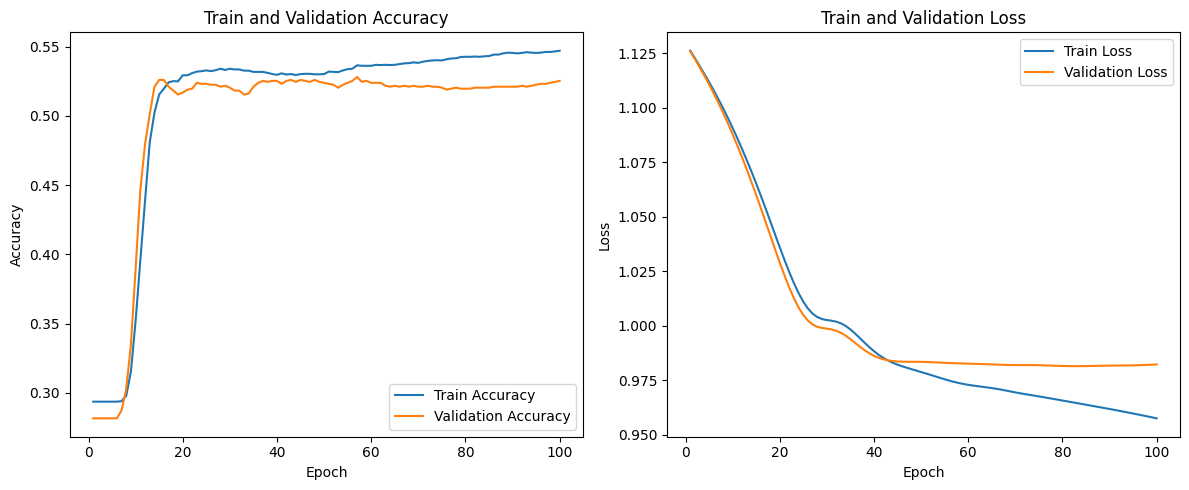

In [47]:
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    return correct / targets.size(0)

train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    if reg == 'l1':
        l1_loss = model.l1_loss()
        loss += alpha * l1_loss
    elif reg == 'l2':
        l2_loss = model.l2_loss()
        loss += alpha * l2_loss

    loss.backward()
    optimizer.step()
    
    train_accuracy = calculate_accuracy(outputs, y_train)
    train_accuracies.append(train_accuracy)
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid)
        valid_loss = criterion(valid_outputs, y_valid)
        valid_accuracy = calculate_accuracy(valid_outputs, y_valid)
        valid_accuracies.append(valid_accuracy)
        valid_losses.append(valid_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Valid Loss: {valid_loss.item():.4f}, Valid Acc: {valid_accuracy:.4f}')

# Plot the accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Results for varying the number of hidden units and layers

| Hidden Units | # Hidden Layers | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss |
|--------------|----------------|----------------|---------------------|------------|-----------------|
| 32           | 1              | 0.5441         | 0.5274              | 0.9547     | 0.9837          |
| 32           | 2              | 0.5495         | 0.5323              | 0.9483     | 0.9861          |
| 32           | 3              | 0.5448         | 0.5225              | 0.9546     | 0.9872          |
| 64           | 1              | 0.5546         | 0.5204              | 0.9396     | 0.9911          |
| 64           | 2              | 0.5734         | 0.5225              | 0.9133     | 0.9966          |
| 64           | 3              | 0.5797         | 0.5211              | 0.9051     | 1.0065          |
| 128          | 1              | 0.5794         | 0.5190              | 0.9042     | 0.9936          |
| 128          | 2              | 0.6303         | 0.5211              | 0.8335     | 1.0341          |
| 128          | 3              | 0.7127         | 0.4831              | 0.6893     | 1.1963          |

Based on the initial results, the best model is the one with 64 hidden units and 2 hidden layers, with a train accuracy of 0.5734 and a validation accuracy of 0.5225.

Let's see if we can further improve the model with other regularization techniques.

# Dropout results with different inclusion probabilities

| Inclusion Probability | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss |
|-----------------------|----------------|---------------------|------------|-----------------|
| 0.6                   | 0.5355         | 0.5218              | 0.9820     | 0.9822          |
| 0.7                   | 0.5355         | 0.5218              | 0.9820     | 0.9822          |
| 0.85                  | 0.5407         | 0.5197              | 0.9691     | 0.9860          |
| 0.97                  | 0.5450         | 0.5239              | 0.9567     | 0.9865          |

It seems that a very high inclusion probability has a marginal effect on the validation accuracy, though probably not enough to be statistically significant.

# L1 regularization results

| Alpha | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss |
|-----------------------|----------------|---------------------|------------|-----------------|
| 5e-4                  | 0.5330         | 0.5147              | 1.0255     | 0.9831          |
| 1e-3                  | 0.5341         | 0.5183              | 1.0471     | 0.9839          |
| 5e-3                  | 0.4542         | 0.4677              | 1.1763     | 1.0052          |
| 5e-2                  | 0.4542         | 0.4677              | 2.1595     | 1.0731          |

It seems that l1 regularization is not a good fit for this model... it actually had a negative effect on the validation accuracy and loss.

# L2 regularization results

| Alpha | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss |
|-----------------------|----------------|---------------------|------------|-----------------|
| 5e-4                  | 0.5260         | 0.5126              | 1.1570     | 0.9888          |
| 1e-3                  | 0.5423         | 0.5211              | 0.9658     | 0.9889          |
| 5e-3                  | 0.5420         | 0.5239              | 0.9998     | 0.9840          |
| 5e-2                  | 0.5235         | 0.5140              | 1.1638     | 0.9871          |

It seems that l2 regularization with an alpha of 5e-3 is the best fit for this model of the lot, however still performs slightly worse than the model without regularization. Higher alphas do however help to reduce the overfitting of the model.

---

It seems that there are two possible issues here:
1. The model is too simple and is not able to capture the complexity of the data (albeit increasing complexity decreases the validation accuracy and increases overfitting)
2. The data itself is too noisy or contains too much irrelevant information.

### Next steps:
- Experiment with different feature selections - particularly with less features.
- experiment with different model architectures and layers, as well as different combinations of dropout and regularization
- Research into different techniques that could help boost model performance